In [98]:
# imports
import pandas as p                              # pandas
import numpy as np                              # numpy
import datetime as dt                           # datetime module for time intervals
from sklearn.cluster import DBSCAN              # DBSCAN algorithm
from sklearn.cluster import HDBSCAN             # HDBSCAN algorithm
import hdbscan as hdbs                          # improved (faster) HDBSCAN https://github.com/scikit-learn-contrib/hdbscan, https://joss.theoj.org/papers/10.21105/joss.00205
import matplotlib.pyplot as plt                 # plot
import gc                                       # garbage collector
from scipy.spatial import ConvexHull            # ConvexHulls for clusters
from shapely.geometry.polygon import Polygon    # for operations on clusters

# map plotting
import shapely as shpl               
import plotly.express as px
import plotly.offline as po
import plotly.graph_objects as go


# constants
FOLDER_PATH = "../dataset/2019/"
FILE_NAME = 'cleaned_2019_01-03.csv'
SPEED_THRESHOLD = 0.25 # nautical knots
ABSURD_SPEED_THRESHOLD = 107 # nautical knots
POINTS_THRESHOLD = 50
KNOTS_CONST = 1.943845249221964 # constant used to convert from m/s to nautical knots
EARTH_RADIUS_KM = 6378.137 # average value, taken from WGS-84 standard and used by geopy https://github.com/geopy/geopy/blob/master/geopy/distance.py
EARTH_RADIUS_M = 6378137
LAT_MIN = 18.76651
LAT_MAX = 22.63089
LON_MIN = -160.11085
LON_MAX = -154.38957
LOST_TIME_THRESHOLD_SECONDS = dt.timedelta(seconds=600) # 10 minutes
EXIT_TIME_THRESHOLD_HOURS = dt.timedelta(hours=12) # half day

Import source csv into a dataframe

In [99]:
clean_df = p.read_csv(FOLDER_PATH + FILE_NAME)
print(f'Dataframe shape: {clean_df.shape}')
print(clean_df.columns)
print(clean_df.shape)

/tmp/ipykernel_46277/4039637272.py:1: DtypeWarning:

Columns (7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.



Dataframe shape: (5415168, 17)
Index(['MMSI', 'BaseDateTime', 'LAT', 'LON', 'SOG', 'COG', 'Heading',
       'VesselName', 'IMO', 'CallSign', 'VesselType', 'Status', 'Length',
       'Width', 'Draft', 'Cargo', 'TransceiverClass'],
      dtype='object')
(5415168, 17)


Columns dtypes optimization in order to reduce RAM usage <br>
(=casting to smaller dtypes)

In [100]:
optimized_df = p.DataFrame()

# MMSI - 9 digits number, converted from int64 to int32
optimized_df['MMSI'] = clean_df['MMSI'].astype('int32')

# BaseDateTime - from str to numpy.datetime64 (68 bytes -> 40 Bytes)
optimized_df['BaseDateTime'] = clean_df['BaseDateTime'].astype('datetime64[s]')

# LAT - No action. Just want to make sure to not loose precision 
optimized_df['LAT'] = clean_df['LAT']

# LON - No action. Just want to make sure to not loose precision 
optimized_df['LON'] = clean_df['LON']

# SOG - No action
optimized_df['SOG'] = clean_df['SOG']

# COG - from float64 to float32. The loss of precision is negligible, as per AIS specs
# the maximum allowed value is 360 degrees, relative to true north
optimized_df['COG'] = clean_df['COG'].astype('float32')

# Heading - from float64 to float32. The loss of precision is negligible, as per AIS specs
# the maximum allowed value is 511, meaning 'no data'.
optimized_df['Heading'] = clean_df['Heading'].astype('float32')

# VesselName - specify string dtype
optimized_df['VesselName'] = clean_df['VesselName'].astype(p.StringDtype())

# IMO - specify string dtype
optimized_df['IMO'] = clean_df['IMO'].astype(p.StringDtype())

# CallSign - specify string dtype
optimized_df['CallSign'] = clean_df['CallSign'].astype(p.StringDtype())

# VesselType - from float64 to int16. Following AIS specification, VesselType maximum value is around 1000
clean_df['VesselType'] = clean_df['VesselType'].fillna(value=0) # replaces all None values with zero.
optimized_df['VesselType'] = clean_df['VesselType'].astype('int16')

# Status - from float64 to int8. Following AIS specification, there are 16 (0-15) status codes
clean_df['Status'] = clean_df['Status'].fillna(value=99) # since 0 is a valid status code, 99 is used as a placeholder for None values
optimized_df['Status'] = clean_df['Status'].astype('int8')

# Length - from float64 to int16. Any floating point value is truncated to the closest integer.
# This is done on purpouse as an error of fractions of a meter is bearable.
clean_df['Length'] = clean_df['Length'].fillna(value=0)
optimized_df['Length'] = clean_df['Length'].astype('int16')

# Width - from float64 to int16. Any floating point value is truncated to the closest integer.
# This is done on purpouse as an error of fractions of a meter is bearable.
clean_df['Width'] = clean_df['Width'].fillna(value=0)
optimized_df['Width'] = clean_df['Width'].astype('int16')

# Draft - from float64 to float32
optimized_df['Draft'] = clean_df['Draft'].astype('float32')

# Cargo - from float64 to int16. Similar to VesselType
clean_df['Cargo'] = clean_df['Cargo'].fillna(value=0)
optimized_df['Cargo'] = clean_df['Cargo'].astype('int16')

# TransceiverClass - from string object to boolean. The new column ('IsClassA') holds True if the transceiver 
# is of type 'class A', false if it is of type 'class B'
optimized_df['IsClassA'] = clean_df['TransceiverClass'].map({'A':True, 'B':False})

# Round lat and lon values to 4 decimal digits (instead of 5)
optimized_df[['LAT','LON']] = optimized_df[['LAT','LON']].round(4)

print(clean_df.info())

print(optimized_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5415168 entries, 0 to 5415167
Data columns (total 17 columns):
 #   Column            Dtype  
---  ------            -----  
 0   MMSI              int64  
 1   BaseDateTime      object 
 2   LAT               float64
 3   LON               float64
 4   SOG               float64
 5   COG               float64
 6   Heading           float64
 7   VesselName        object 
 8   IMO               object 
 9   CallSign          object 
 10  VesselType        float64
 11  Status            float64
 12  Length            float64
 13  Width             float64
 14  Draft             float64
 15  Cargo             float64
 16  TransceiverClass  object 
dtypes: float64(11), int64(1), object(5)
memory usage: 702.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5415168 entries, 0 to 5415167
Data columns (total 17 columns):
 #   Column        Dtype        
---  ------        -----        
 0   MMSI          int32        
 1   BaseDateTim

Source: Pallotta, G., Vespe, M., & Bryan, K. (2013). Vessel Pattern Knowledge Discovery from AIS Data: A Framework for Anomaly Detection and Route Prediction. Entropy, 15(12), 2218–2245. https://doi.org/10.3390/e15062218

‌TREAD algorithm (pages 2223-2231)

In [101]:
def great_circle_distance_vectorized(lat_left, lon_left, lat_right, lon_right):
    '''Function used to calculate the Great-Circle distance between two GPS coordinates'''    
    lon_left, lat_left, lon_right, lat_right = map(np.radians, [lon_left, lat_left, lon_right, lat_right])
    deg_lon = lon_right - lon_left
    deg_lat = lat_right - lat_left
    a = np.sin(deg_lat/2.0)**2 + np.cos(lat_left) * np.cos(lat_right) * np.sin(deg_lon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    meters = EARTH_RADIUS_M * c
    return meters

V_s = [] # List of dataframes. Each dataframe represents a Vessel (and its journey)

# From the complete db, select only the necessary columns
optimized_df = optimized_df[['MMSI', 'BaseDateTime', 'LAT', 'LON', 'SOG', 'COG', 'Heading',
                            'VesselName', 'VesselType', 'Status', 'Length',
                            'Width', 'Draft', 'IsClassA']].copy()
# Drop duplicates, just in case
optimized_df.drop_duplicates(subset=['MMSI', 'BaseDateTime'], keep='first', inplace=True, ignore_index=True)
optimized_df = optimized_df.sort_values(by='BaseDateTime')

reference_list_of_mmsi = p.unique(optimized_df['MMSI'])

# for each ship
for mmsi in reference_list_of_mmsi:
    # Extract all points generated by the ship
    appendDF = p.DataFrame(optimized_df[optimized_df['MMSI'] == mmsi])
    # Add a new column for storing the average speed between the current point and the previous
    appendDF['Avg_Speed'] = p.Series(dtype=p.Float64Dtype())
    # Add a new column for storing the status of the ship (according to TREAD algorithm, see above)
    appendDF['EstimatedStatus'] = np.nan
    # Rename the dataframe to the corresponding ship MMSI
    appendDF.Name = mmsi
    # reset the index of the dataframe
    appendDF.reset_index(inplace=True)

    # next step: calculate the avg_speed (distance/time) in order to find stationary points. (SOG is not always reliable)
    # for the distance, the great-circle distance is used in order to account for earth curvature
    
    # save a shifted-by-one-row version of the db, so that "previous" points can be joined with "current" points
    shiftedDF = appendDF[['BaseDateTime','LAT', 'LON']].shift(1).copy()
    # the resulting df has (for each row) a pair of points. The left one is antecedent to the right one
    pairsOfPointsDF = shiftedDF.iloc[1:].join(appendDF[['BaseDateTime', 'LAT', 'LON', 'SOG']].iloc[1:], lsuffix='_left', rsuffix='_right')
    # calculate average speed for each row of the 'pairsOfPointsDF' df (each row represents a pair of points)
    # add a new column that holds the time difference between the two points of the row
    pairsOfPointsDF['DeltaTime'] = p.to_datetime(pairsOfPointsDF['BaseDateTime_right']) - p.to_datetime(pairsOfPointsDF['BaseDateTime_left'])
    # add a new column that holds the distance (in meters) between the two points of the same row
    pairsOfPointsDF['Distance'] = great_circle_distance_vectorized( pairsOfPointsDF['LAT_left'],
                                                                    pairsOfPointsDF['LON_left'],
                                                                    pairsOfPointsDF['LAT_right'],
                                                                    pairsOfPointsDF['LON_right']
                                                                    )
    # calculate average speed (in m/s)
    pairsOfPointsDF['Speed'] = pairsOfPointsDF['Distance'] / pairsOfPointsDF['DeltaTime'].dt.total_seconds()

    # sometimes a vessel can stop reporting its position and re-appear too far away from its last known location.
    # In this case it makes little sense to calculate the avg_speed. (np.nan multiplied by any number returns np.nan)
    
    # condition used to determine if the ship is "lost"
    lost_condition = (pairsOfPointsDF['DeltaTime'] > LOST_TIME_THRESHOLD_SECONDS)
    # another codition used to determin if the ship has left the domain for a significant amount of time
    exit_condition = (pairsOfPointsDF['DeltaTime'] > EXIT_TIME_THRESHOLD_HOURS)
    # the avg_speed of the points following the ones considered "lost" is set to nan
    pairsOfPointsDF.loc[lost_condition, 'Speed'] = np.nan
    # any nan point of the 'Speed' column is set to the corresponging 'SOG' value (if available)
    pairsOfPointsDF['Speed'] = pairsOfPointsDF['Speed'].fillna(pairsOfPointsDF['SOG']/KNOTS_CONST)
    # new empty status column
    pairsOfPointsDF['EstimatedStatus'] = p.Series(dtype=p.StringDtype())
    # set the status of the last and first points before and after a small interruption
    pairsOfPointsDF.loc[lost_condition.shift(-1, fill_value=False), 'EstimatedStatus'] = 'lost'
    pairsOfPointsDF.loc[lost_condition, 'EstimatedStatus'] = 'return'
    # set the status of the last and first points before and after a big interruption
    pairsOfPointsDF.loc[exit_condition.shift(-1, fill_value=False), 'EstimatedStatus'] = 'exit'
    pairsOfPointsDF.loc[exit_condition, 'EstimatedStatus'] = 'entry'
    
    # convert the speed from meters to nautical knots
    pairsOfPointsDF['Speed'] = pairsOfPointsDF['Speed'] * KNOTS_CONST
    pairsOfPointsDF['Speed'] = pairsOfPointsDF['Speed'].round(decimals=2)
    
    # save the speed values to the ship df
    appendDF['Avg_Speed'] = pairsOfPointsDF['Speed'].copy()
    # round the final value to 2 decimal digits
    # The first row of each ship has its "Avg_Speed" field set equal to the SOG
    appendDF.at[appendDF.index[0], 'Avg_Speed'] = appendDF.at[appendDF.index[0], 'SOG']
    # Any row where avg_speed is set to np.nan is replaced with the SOG value
    appendDF.fillna({'Avg_Speed' : appendDF['SOG']}, inplace=True)
    # Sometimes a vessel may broadcast an impossible GPS location. This is detected by looking for 
    # absurd Avg_Speed values. Any point that fits this description is then dropped.
    appendDF = appendDF[appendDF['Avg_Speed'] < ABSURD_SPEED_THRESHOLD]
    # Copy the estimated status column in the final ship df
    appendDF['EstimatedStatus'] = pairsOfPointsDF['EstimatedStatus'].copy()
    
    # drop the first column (generated during all the processing above)
    appendDF.drop('index', axis=1, inplace=True)
    # save the dataframe to the vessels list
    V_s.append(appendDF)

display(V_s[-1].head(10))

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,VesselType,Status,Length,Width,Draft,IsClassA,Avg_Speed,EstimatedStatus
0,248531000,2019-03-29 17:09:21,21.2406,-159.9439,11.7,89.099998,86.0,<NA>,0,0,0,0,NaN,True,11.70,<NA>
1,248531000,2019-03-29 17:45:42,21.2409,-159.8170,11.9,89.300003,91.0,<NA>,0,0,0,0,NaN,True,11.90,return
2,248531000,2019-03-29 17:46:52,21.2409,-159.8130,11.8,90.199997,92.0,<NA>,0,0,0,0,NaN,True,11.53,<NA>
3,248531000,2019-03-29 17:56:41,21.2409,-159.7782,11.9,91.199997,92.0,<NA>,0,0,0,0,NaN,True,11.92,<NA>
4,248531000,2019-03-29 17:57:52,21.2409,-159.7740,12.0,90.800003,92.0,<NA>,0,0,0,0,NaN,True,11.93,<NA>
5,248531000,2019-03-29 17:59:13,21.2408,-159.7691,12.0,90.599998,92.0,<NA>,0,0,0,0,NaN,True,12.20,<NA>
6,248531000,2019-03-29 18:00:52,21.2407,-159.7632,12.1,95.199997,92.0,<NA>,0,0,0,0,NaN,True,12.02,<NA>
7,248531000,2019-03-29 18:02:02,21.2406,-159.7590,12.1,91.199997,93.0,<NA>,0,0,0,0,NaN,True,12.11,<NA>
8,248531000,2019-03-29 18:03:12,21.2404,-159.7548,12.2,91.199997,92.0,<NA>,0,0,0,0,NaN,True,12.12,<NA>
9,248531000,2019-03-29 18:04:22,21.2403,-159.7506,12.2,95.000000,92.0,<NA>,0,0,0,0,NaN,True,12.11,<NA>


In [77]:
# delete unused dataframe from RAM in order to save memory
# according to StackOverflow, this is the best way: 
# https://stackoverflow.com/questions/64368565/delete-and-release-memory-of-a-single-pandas-dataframe

del pairsOfPointsDF
del appendDF
del shiftedDF
del clean_df
gc.collect()

25

Next part of the TREAD algorithm</br>

Consider as stationary all points where the estimated average speed is lower then a set threshold</br>
Consider the first (entry) and last (exit) recorded points of each ship as 'stationary', regardless of the estimated speed.</br>
Set all remaing points as 'sailing'</br>

Removed duplicate entry or exit point at index [3531].
Previous ship len: 35098
Current ship len: 35097
Removed duplicate entry or exit point at index [17898, 17899].
Previous ship len: 23549
Current ship len: 23547
Removed duplicate entry or exit point at index [1966].
Previous ship len: 1967
Current ship len: 1966
Removed duplicate entry or exit point at index [6942].
Previous ship len: 7771
Current ship len: 7770
Removed duplicate entry or exit point at index [1476].
Previous ship len: 5090
Current ship len: 5089
Removed duplicate entry or exit point at index [3790].
Previous ship len: 3791
Current ship len: 3790
Removed duplicate entry or exit point at index [796].
Previous ship len: 6316
Current ship len: 6315
Removed duplicate entry or exit point at index [8518].
Previous ship len: 8519
Current ship len: 8518
Removed duplicate entry or exit point at index [3249].
Previous ship len: 16198
Current ship len: 16197
Removed duplicate entry or exit point at index [373, 1470].
Previous 

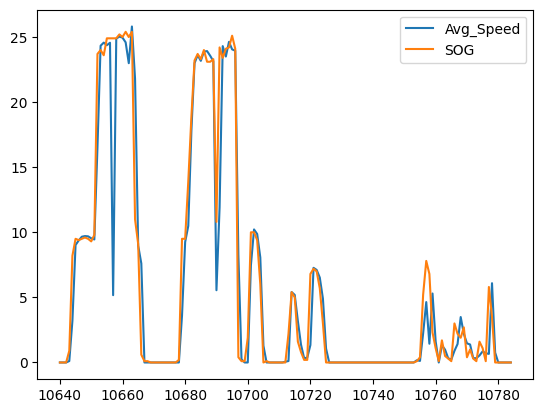

In [78]:
# for each vessel (dataframe) in the V_s list,
for index, shipDF in enumerate(V_s):
    # set the status of each point where the avg_speed is lower than the given threshold, to 'stationary'
    shipDF['EstimatedStatus'] = np.where(((shipDF["Avg_Speed"] <= SPEED_THRESHOLD) &
                                         (shipDF['EstimatedStatus'].isnull())),
                                         'stationary', shipDF['EstimatedStatus'])
    # set all remaining points as "sailing"
    shipDF['EstimatedStatus'] = np.where(((shipDF["Avg_Speed"] > SPEED_THRESHOLD) & 
                                         (shipDF['EstimatedStatus'].isnull())),
                                          'sailing', shipDF['EstimatedStatus'])
    # set the first and last points of each ship as "entry" and "exit" points respectively
    shipDF.loc[shipDF.index[0:1], 'EstimatedStatus'] = 'entry'
    shipDF.loc[shipDF.index[-1:], 'EstimatedStatus'] = 'exit'

    # sometimes a few consecutive points (for the same vessel) might be all with status 'entry' or 'exit'
    # this is unwanted and only one of those points is kept.
    # The rule is: keep the last of any consecutive 'entry' point and keep the first of any consecutive 'exit' point
    
    tempDF = shipDF[(shipDF['EstimatedStatus'] == 'entry') | (shipDF['EstimatedStatus'] == 'exit')] 

    condition_entry  = (
                        (tempDF['EstimatedStatus'] == 'entry') &
                        (tempDF['EstimatedStatus'].shift(-1) == tempDF['EstimatedStatus'])
                        )
    condition_exit =(
                        (tempDF['EstimatedStatus'] == 'exit') &
                        (tempDF['EstimatedStatus'].shift(1) == tempDF['EstimatedStatus'])
                    )
    bad_entry_index = tempDF[condition_entry].index.to_list()
    bad_exit_index = tempDF[condition_exit].index.to_list()
    if bad_entry_index or bad_exit_index:
        final_bad_index = bad_entry_index + bad_exit_index
        final_bad_index.sort()
        print(f'Removed duplicate entry or exit point at index {final_bad_index}.')
        print(f'Previous ship len: {shipDF.shape[0]}')
        shipDF = shipDF.drop(index=final_bad_index).reset_index()
        print(f'Current ship len: {shipDF.shape[0]}')
    
    V_s[index] = shipDF.copy()

print(V_s[3].info())

del shipDF
del tempDF
gc.collect()

# print a dataframe and some points just to check
interval = range(10640,10785)
#print(V_s[3].iloc[interval])
plt.plot(V_s[3]['Avg_Speed'].iloc[interval])
plt.plot(V_s[3]['SOG'].iloc[interval])
plt.legend(['Avg_Speed', 'SOG'])


In [79]:
concatDF = p.concat(V_s, ignore_index=True).copy()

# Extract all the stationary points in a single dataframe

stationaryDF = p.DataFrame(columns=V_s[0].columns) # new empty df

stationaryDF = concatDF[(concatDF['EstimatedStatus'] == 'stationary') |
                        (concatDF['EstimatedStatus'] == 'entry') |
                        (concatDF['EstimatedStatus'] == 'exit')
                        ].copy()

stationaryDF.reset_index(inplace=True)

print(f'{(stationaryDF.shape[0]/optimized_df.shape[0]) * 100: .2f}% of points are stationary!')

 65.34% of points are stationary!


In [80]:
# Some computationl tricks in order to save some time

# Group-by same (lat,lon) pairs and count occurrencies
groupedDF = stationaryDF.groupby(['LAT', 'LON']).size().reset_index(name='Weight')

print("Pair with most occurrencies: \n" + str(groupedDF.iloc[groupedDF['Weight'].idxmax(), :]) + '\n')

# Apply log2() (base-2 logarithm) to the 'weight' column in order to rescale its values
groupedDF['Weight'] = np.round(
                                np.log2(groupedDF['Weight']),
                                decimals=0
                            )
# The minimum weight should be 1, so any zero is replaced
groupedDF['Weight'] = groupedDF['Weight'].replace(0,1)

display(p.concat([groupedDF.head(5), groupedDF.tail(5)]))

print("Pair with most occurrencies: \n" + str(groupedDF.iloc[groupedDF['Weight'].idxmax(), :]) + '\n')

Pair with most occurrencies: 
LAT          21.2970
LON        -158.1065
Weight    59926.0000
Name: 21860, dtype: float64



,LAT,LON,Weight
0,18.7665,-155.7773,1.0
1,18.7666,-156.9702,1.0
2,18.7669,-156.6011,1.0
3,18.7669,-156.5696,1.0
4,18.7671,-159.1110,1.0
31267,22.6307,-156.9234,1.0
31268,22.6307,-156.3146,1.0
31269,22.6308,-158.4875,1.0
31270,22.6308,-156.8662,1.0
31271,22.6308,-155.5218,1.0


Pair with most occurrencies: 
LAT        21.2970
LON      -158.1065
Weight     16.0000
Name: 21860, dtype: float64



DBSCAN(eps=0.075, min_samples=10) len: 31272, num of clusters: 48


,LAT,LON,Weight,Label
0,18.7665,-155.7773,1.0,1
1,18.7666,-156.9702,1.0,-1
2,18.7669,-156.6011,1.0,-1
3,18.7669,-156.5696,1.0,-1
4,18.7671,-159.1110,1.0,-1
31267,22.6307,-156.9234,1.0,-1
31268,22.6307,-156.3146,1.0,-1
31269,22.6308,-158.4875,1.0,-1
31270,22.6308,-156.8662,1.0,45
31271,22.6308,-155.5218,1.0,47


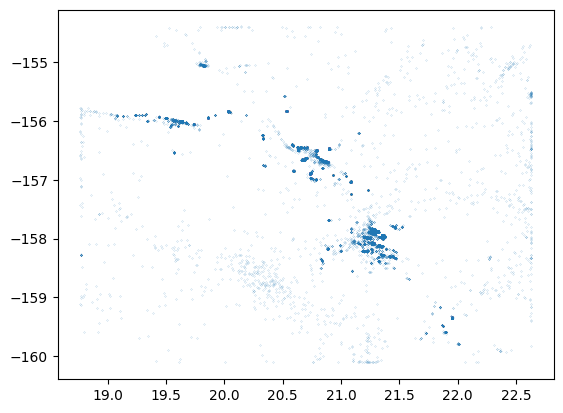

In [95]:
# Run DBSCAN algorithm on the stationary points

# this scatter plot gives a rough idea of how the point should look like plotted on a map
plt.scatter(groupedDF.iloc[:,0], groupedDF.iloc[:,1], s=0.01)

# inizitalize dbscan object with parameters. TODO: test multiple parameters combinations
dbscan = DBSCAN(eps=0.075, min_samples=10)

estimator = dbscan.fit(
                    X=groupedDF.iloc[:, 0:2], 
                    sample_weight=groupedDF['Weight']
                    )

print(str(estimator) + " len: " + str(len(estimator.labels_)) + ", num of clusters: " + str(max(estimator.labels_)))

# Add labels to the dataframe
groupedDF['Label'] = estimator.labels_

display(p.concat([groupedDF.head(5), groupedDF.tail(5)]))

In [96]:
# plot the result of the DBSCAN clustering on a map (to have a look at the effects of the parameters)

def points_plotter(clustered : p.DataFrame, not_clustered : p.DataFrame, model, dbscanFlag : bool):
    '''Function used to plot the results of dbscan and hdbscan\n
    Takes as input two dataframes: clusterd and not_clustered, both containing
    points that were successfully labelled or not, respectively'''
    if dbscanFlag:
        my_title = 'DBSCAN. Eps: ' + str(model.get_params()['eps']) + ', min_size: ' + str(model.get_params()['min_samples'])
    else:
        my_title = 'H-DBSCAN. Min Eps: ' + str(model.get_params()['cluster_selection_epsilon']) + \
            ', min_size: ' + str(model.get_params()['min_cluster_size']) + \
            ', max_size: ' + str(model.get_params()['max_cluster_size'])
    
    # plot clustered points on a map
    fig = px.scatter_mapbox(data_frame = clustered,
                            lon = clustered['LON'],
                            lat= clustered['LAT'],
                            zoom = 7,
                            color = clustered['Label'],
                            title = my_title,
                            color_continuous_scale='portland'  #portland
                            )

    # add unclustered points
    fig.add_scattermapbox(
                          lat= not_clustered['LAT'],
                          lon= not_clustered['LON'],
                          marker={'color':'white'},
                          uid=1
                          )

    # add domain border
    fig.add_trace(go.Scattermapbox(
                                    mode = 'lines',
                                    lon = [LON_MIN, LON_MIN, LON_MAX, LON_MAX, LON_MIN],
                                    lat = [LAT_MIN, LAT_MAX, LAT_MAX, LAT_MIN, LAT_MIN],
                                    marker = {'size':10,
                                              'color': 'red'},
                                    uid=2,
                                    below=0
                                    ))
    
    # Add polygons on map
    for label in clustered['Label'].unique():
        groupLATLONDF = clustered[clustered['Label']==label][['LAT', 'LON']]
        hull = ConvexHull(groupLATLONDF)
        hull_lon = [groupLATLONDF['LON'].reset_index().iloc[vertex] for vertex in hull.vertices]
        hull_lat = [groupLATLONDF['LAT'].reset_index().iloc[vertex] for vertex in hull.vertices]
    
        hull_lon = [serie.tolist()[1] for serie in hull_lon]
        hull_lat = [serie.tolist()[1] for serie in hull_lat]
    
        fig.add_trace(go.Scattermapbox(
            lat=hull_lat + [hull_lat[0]],
            lon=hull_lon + [hull_lon[0]],
            mode='lines',
            line=dict(color='black', width=2),
            below=0,
            showlegend=False,
            name='WP_' + str(label)
            #fill='toself',
            #fillcolor='rgba(255,0,0,0.2)'
        ))

    fig.update_layout(mapbox_style = 'open-street-map',
                      margin={'r':0, 't':40, 'l':0, 'b':0},
                      )
    po.plot(fig)

    

clusteredPointsDF = groupedDF[groupedDF['Label'] != -1].copy()
outliersDF = groupedDF[groupedDF['Label'] == -1].copy()
clusteredPointsDF.reset_index(inplace=True)
outliersDF.reset_index(inplace=True)

display(p.concat([clusteredPointsDF.head(5), clusteredPointsDF.tail(5)]))

points_plotter(clustered=clusteredPointsDF,
               not_clustered=outliersDF,
               model=estimator,
               dbscanFlag=True)



,index,LAT,LON,Weight,Label
0,0,18.7665,-155.7773,1.0,1
1,7,18.7673,-155.9327,1.0,1
2,10,18.7677,-155.7892,1.0,1
3,11,18.7680,-158.2825,1.0,0
4,13,18.7682,-155.9034,1.0,1
30258,31260,22.6305,-158.4078,1.0,46
30259,31262,22.6305,-155.6834,1.0,47
30260,31263,22.6305,-155.5342,1.0,47
30261,31270,22.6308,-156.8662,1.0,45
30262,31271,22.6308,-155.5218,1.0,47


Hierarchical DBSCAN

In [83]:
# Since the current sklearn hdbscan implementation does not allow to pass the weights of points as input,
# the DataFrame that stores stationary points needs a little change: instead of passing the weights for each
# coordinate, each line representing a coordinate is going to be duplicated for the same amount specified by its own weight

print(f'The new DF should have about {groupedDF.shape[0]} * {groupedDF["Weight"].mean(), 3} = {groupedDF.shape[0] * groupedDF["Weight"].mean()} rows.')

repeated_indices = np.repeat(groupedDF.index, groupedDF['Weight'])

h_groupedDF = groupedDF.loc[repeated_indices, ['LAT', 'LON']].reset_index(drop=True)

print('Rows of the new DF: {}'.format(h_groupedDF.shape[0]))

print(f'The new DF, if a "groupby" is applied again, should have the same number of rows of the original: {groupedDF.shape[0]} = {h_groupedDF.value_counts().shape[0]}')


The new DF should have about 31272 * (2.2243220772576104, 3) = 69559.0 rows.
Rows of the new DF: 69559
The new DF, if a "groupby" is applied again, should have the same number of rows of the original: 31272 = 31272


In [84]:
# Run H-DBSCAN algorithm on the stationary points

# inizitalize dbscan object with parameters. TODO: test multiple parameters combinations
h_dbscan = hdbs.HDBSCAN(min_cluster_size=30,
                        cluster_selection_epsilon=0.075,
                        max_cluster_size=10_000)

h_labels = h_dbscan.fit_predict(
                    X=h_groupedDF.loc[:, ['LAT','LON']]
                    )

# this is necessary in order to pass the params to the function that plots the clusters
temp_model = HDBSCAN(min_cluster_size=30,
                  cluster_selection_epsilon=0.075,
                  max_cluster_size=10_000
                  )

print(str(h_dbscan) + " len: " + str(len(h_labels)) + ", num of clusters: " + str(max(h_labels)))

# Add labels to the dataframe
h_groupedDF['Label'] = h_labels


display(h_groupedDF)
#print(groupedDF['Label'].max())

HDBSCAN(cluster_selection_epsilon=0.075, max_cluster_size=10000,
        min_cluster_size=30) len: 69559, num of clusters: 35


,LAT,LON,Label
0,18.7665,-155.7773,-1
1,18.7666,-156.9702,-1
2,18.7669,-156.6011,-1
3,18.7669,-156.5696,-1
4,18.7671,-159.1110,-1
...,...,...,...
69554,22.6307,-156.9234,-1
69555,22.6307,-156.3146,11
69556,22.6308,-158.4875,-1
69557,22.6308,-156.8662,-1


In [85]:
# Show the result of h-dbscan on a map

clusteredPointsDF = h_groupedDF[(h_groupedDF['Label'] != -1)].copy()
outliersDF = h_groupedDF[h_groupedDF['Label'] == -1].copy()

# plot points and clusters
points_plotter(clustered=clusteredPointsDF,
               not_clustered=outliersDF,
               model=temp_model,
               dbscanFlag=False)

Plot a heatmap using all the points, even the non-stationary ones

In [86]:
%%script false --no-raise-error
# the code above is used to prevent the Python kernel from running this cell (https://stackoverflow.com/a/56247673/24805169)


concatDF[['LAT','LON']] = concatDF[['LAT','LON']].round(3)

heatmapDF = concatDF.groupby(['LAT','LON']).size().reset_index(name='Weight')

# Apply log2() (base-2 logarithm) to the 'weight' column in order to rescale its values
heatmapDF['Weight'] = np.round(
                                np.log2(heatmapDF['Weight']),
                                decimals=0
                            )
# The minimum weight should be 1, so any zero is replaced
#heatmapDF['Weight'].replace(0,1,inplace=True)


print("Pair with most occurrencies: \n" + str(heatmapDF.iloc[heatmapDF['Weight'].idxmax(), :]) + '\n')
print(concatDF.shape)
print(heatmapDF.shape)


In [87]:
%%script false --no-raise-error
# the code above is used to prevent the Python kernel from running this cell (https://stackoverflow.com/a/56247673/24805169)

fig2 = px.density_mapbox(
    data_frame=heatmapDF,
    lat='LAT',
    lon='LON',
    z='Weight',
    radius=5,
    zoom=6,
    mapbox_style='open-street-map'
)
fig2.update_layout(mapbox_style = 'open-street-map',
                    margin={'r':0, 't':40, 'l':0, 'b':0}
                    )
                    
po.plot(fig2)


### Waypoints and Routes identification</br>

##### Waypoints


In [88]:
num_of_wp = h_groupedDF['Label'].max()

# Creation of a df for storing the Waypoints
waypointsDF = p.DataFrame()
waypointsDF['Name'] = ['WP_' + str(i) for i in range(0, num_of_wp+1)]
waypointsDF['ConvexHullObj'] = p.Series()  # empty column
waypointsDF['VerticesIndex'] = p.Series() # empty column
waypointsDF['LAT'] = p.Series() # empty column
waypointsDF['LON'] = p.Series() # empty column
waypointsDF['Coords'] = p.Series() # empty column
waypointsDF['PolygonObj'] = p.Series() # empty column
# Exclude non-clustered (noise) points
onlyClusteredPointsDF = h_groupedDF[h_groupedDF['Label'] != -1].copy()


for wp_label in onlyClusteredPointsDF['Label'].unique():
    # create convex hull object using all points with label = wp_label
    groupLATLONDF = onlyClusteredPointsDF[onlyClusteredPointsDF['Label']==wp_label][['LAT', 'LON']]
    conv_hull = ConvexHull(groupLATLONDF)
    # store the ConvexHull object in the dataframe
    waypointsDF.loc[wp_label, 'ConvexHullObj'] = conv_hull
    # and also store the vertices of the ConvexHull (waypoint)
    waypointsDF.at[wp_label, 'VerticesIndex'] = conv_hull.vertices
    
    # this list comprehension creates a list of series
    hull_lon = [groupLATLONDF['LON'].reset_index().iloc[vertex_idx] for vertex_idx in conv_hull.vertices]
    hull_lat = [groupLATLONDF['LAT'].reset_index().iloc[vertex_idx] for vertex_idx in conv_hull.vertices]
    
    #from the list of series extract the second value of each serie (after converting the serie to list)
    hull_lon = [serie.tolist()[1] for serie in hull_lon]
    hull_lat = [serie.tolist()[1] for serie in hull_lat]

    # save the LAT and LON values to the appropriate row and column
    waypointsDF.at[wp_label, 'LAT'] = hull_lat
    waypointsDF.at[wp_label, 'LON'] = hull_lon

    # zip the LAT and LON values of each row together in a new column (this is needed in order to create a Polygon)
    waypointsDF.at[wp_label, 'Coords'] = list(zip(hull_lon, hull_lat))
    waypointsDF.at[wp_label, 'Coords'].append((hull_lon[0], hull_lat[0]))

    # create a Polygon
    waypointsDF.at[wp_label, 'PolygonObj'] = Polygon(waypointsDF.at[wp_label, 'Coords'])


display(waypointsDF.head())

,Name,ConvexHullObj,VerticesIndex,LAT,LON,Coords,PolygonObj
0,WP_0,<scipy.spatial._qhull.ConvexHull object at 0x7...,"[181, 0, 1, 2, 3, 173, 175, 180]","[20.1383, 19.7438, 19.7615, 19.7636, 19.7791, ...","[-155.0376, -154.7779, -155.0106, -155.0244, -...","[(-155.0376, 20.1383), (-154.7779, 19.7438), (...","POLYGON ((-155.0376 20.1383, -154.7779 19.7438..."
1,WP_1,<scipy.spatial._qhull.ConvexHull object at 0x7...,"[35, 0, 29, 34]","[19.7057, 19.341, 19.5705, 19.6358]","[-156.5188, -156.4086, -156.5374, -156.5532]","[(-156.5188, 19.7057), (-156.4086, 19.341), (-...","POLYGON ((-156.5188 19.7057, -156.4086 19.341,..."
2,WP_2,<scipy.spatial._qhull.ConvexHull object at 0x7...,"[0, 82, 4031, 4033, 2497, 276, 146, 49, 19, 7]","[19.4756, 19.5135, 19.7839, 19.7904, 19.6337, ...","[-156.0164, -156.1925, -156.1446, -156.0623, -...","[(-156.0164, 19.4756), (-156.1925, 19.5135), (...","POLYGON ((-156.0164 19.4756, -156.1925 19.5135..."
3,WP_3,<scipy.spatial._qhull.ConvexHull object at 0x7...,"[0, 30, 29, 1]","[20.1431, 20.1853, 20.1852, 20.1849]","[-155.9979, -155.9039, -155.9038, -155.9038]","[(-155.9979, 20.1431), (-155.9039, 20.1853), (...","POLYGON ((-155.9979 20.1431, -155.9039 20.1853..."
4,WP_4,<scipy.spatial._qhull.ConvexHull object at 0x7...,"[47, 50, 21, 7, 0, 24, 41]","[19.3309, 19.3309, 19.3274, 19.3273, 19.3273, ...","[-155.8867, -155.8865, -155.8869, -155.887, -1...","[(-155.8867, 19.3309), (-155.8865, 19.3309), (...","POLYGON ((-155.8867 19.3309, -155.8865 19.3309..."


<Axes: >

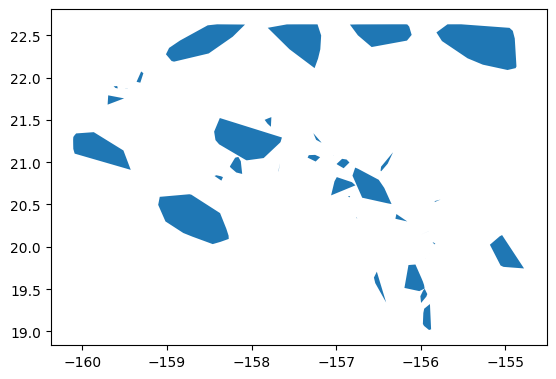

In [89]:
# quick plot the extracted polygons to check if everything worked fine
import geopandas
test = geopandas.GeoSeries(waypointsDF['PolygonObj'])
test.plot()

##### Routes identification

In [90]:
# for each LAT, LON pair, create a shapely.Point
concatDF['PointsObj'] = [shpl.Point(x,y) for (x,y) in concatDF[['LON', 'LAT']].values] #apparently this is faster than usig pandas.Dataframe.apply()

# for each WP, for each row of the entire dataset, check if the point is inside any WP
for name, polygon_obj in  waypointsDF[['Name', 'PolygonObj']].values:
    concatDF[str(name)] = polygon_obj.contains(concatDF['PointsObj']) # create a new column for each wp containing either True or False

# list of column names just created
list_of_columns = [name for name in waypointsDF['Name']]

#idxmax: for each row, return the id (name) of the column containing the first occurrence of the maximum value. There are only bool values so True = 1 > False = 0
# basically returns the name of the WP where the point is contained. If the row has only 'False' values, it returns the first column (this is fixed below)
# this is based on the fact that any given point can belong to either zero or one WP.
concatDF['IsInWP'] = concatDF[list_of_columns].idxmax(axis=1)

# find all rows that have only 'False' values. The '~' negates the values (its like applying the binary NOT)
all_false_rows = concatDF[(~concatDF[list_of_columns]).all(axis=1)].index
# Replace the value in the 'IsInWP' column as 'None'
concatDF.loc[all_false_rows, 'IsInWP'] = None
# drop unnecessary columns
concatDF.drop(list_of_columns, axis=1, inplace=True)

display(concatDF.head(10))

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,VesselType,Status,Length,Width,Draft,IsClassA,Avg_Speed,EstimatedStatus,index,PointsObj,IsInWP
0,338199855,2019-01-01 00:00:00,21.3131,-157.8671,0.0,360.0,511.0,AHUA POINT,60,0,0,0,NaN,True,0.0,entry,NaN,POINT (-157.8671 21.3131),WP_35
1,338199855,2019-01-01 00:01:09,21.3131,-157.8671,0.0,360.0,511.0,AHUA POINT,60,0,0,0,NaN,True,0.0,stationary,NaN,POINT (-157.8671 21.3131),WP_35
2,338199855,2019-01-01 00:02:20,21.3131,-157.8671,0.0,360.0,511.0,AHUA POINT,60,0,0,0,NaN,True,0.0,stationary,NaN,POINT (-157.8671 21.3131),WP_35
3,338199855,2019-01-01 00:03:31,21.3131,-157.8671,0.0,360.0,511.0,AHUA POINT,60,0,0,0,NaN,True,0.0,stationary,NaN,POINT (-157.8671 21.3131),WP_35
4,338199855,2019-01-01 00:04:39,21.3131,-157.8671,0.0,360.0,511.0,AHUA POINT,60,0,0,0,NaN,True,0.0,stationary,NaN,POINT (-157.8671 21.3131),WP_35
5,338199855,2019-01-01 00:05:49,21.3131,-157.8671,0.0,360.0,511.0,AHUA POINT,60,0,0,0,NaN,True,0.0,stationary,NaN,POINT (-157.8671 21.3131),WP_35
6,338199855,2019-01-01 00:07:09,21.3131,-157.8671,0.0,360.0,511.0,AHUA POINT,60,0,0,0,NaN,True,0.0,stationary,NaN,POINT (-157.8671 21.3131),WP_35
7,338199855,2019-01-01 00:08:19,21.3131,-157.8671,0.0,360.0,511.0,AHUA POINT,60,0,0,0,NaN,True,0.0,stationary,NaN,POINT (-157.8671 21.3131),WP_35
8,338199855,2019-01-01 00:09:41,21.3131,-157.8671,0.0,360.0,511.0,AHUA POINT,60,0,0,0,NaN,True,0.0,stationary,NaN,POINT (-157.8671 21.3131),WP_35
9,338199855,2019-01-01 00:11:01,21.3131,-157.8671,0.0,360.0,511.0,AHUA POINT,60,0,0,0,NaN,True,0.0,stationary,NaN,POINT (-157.8671 21.3131),WP_35


IsInWP
WP_35    4028801
None      850697
WP_32     153652
WP_22      84760
WP_14      62103
WP_2       43440
WP_5       31949
WP_19      29337
WP_20      18912
WP_0       17319
WP_30      16835
WP_31      14998
WP_28      14332
WP_34       9395
WP_6        6148
WP_10       3556
WP_12       3555
WP_7        3345
WP_13       2857
WP_24       2436
WP_18       2138
WP_11       2051
WP_23       1864
WP_1        1793
WP_27       1726
WP_21       1548
WP_33       1023
WP_17        995
WP_9         742
WP_29        588
WP_26        563
WP_4         454
WP_15        368
WP_16        282
WP_3         255
WP_25        179
WP_8         140
Name: count, dtype: int64
(5415136, 19)


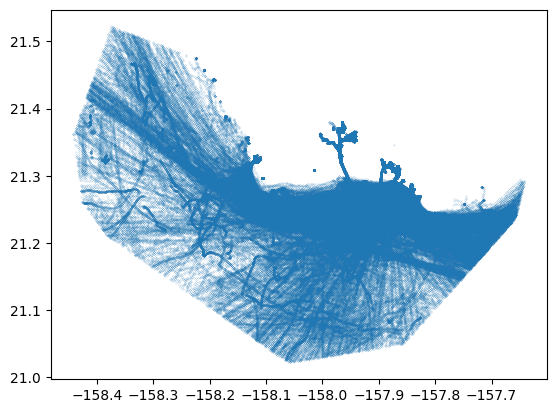

In [91]:
# count the number of points contained in each WP. None -> the ship is at open sea
value_counts = concatDF['IsInWP'].value_counts(dropna=False)
print(value_counts)
print(concatDF.shape)
# quick plot of the WP with the highest amount of points
testDF = concatDF[concatDF['IsInWP'] == value_counts.index[0]]
plt.scatter(testDF['LON'], testDF['LAT'], s=0.01)

#### Routes extraction
For each vessel contained in V_s (used at the beginning of this notebook), create a new column (called 'Route') specifying the current route.</br>If the ship is inside a WP, than the WP name is used in the new column.</br>If the ship is at open sea ('IsInWP' == None) then the Route column is filled in the following way:
* let A and B be the names of the start and end WPs, respectively
* if both A and B are known, the route name is built as A - B
* if either one is missing (pd.NA), the route name is built as "\<NA> - B" or "A - \<NA>"

In [92]:
concatDF['Route'] = p.Series(dtype=p.StringDtype())

for index, unique_mmsi in enumerate(reference_list_of_mmsi):
    vesselDF = concatDF[concatDF['MMSI'] == unique_mmsi].copy()
    
    # create a new column where each row contains the name of the previous WP
    vesselDF['PreviousWP'] = vesselDF['IsInWP'].ffill()
    # create a new column where each row contains the name of the following WP
    vesselDF['NextWP'] = vesselDF['IsInWP'].bfill()
    
    #replace None values with pandas.NA, which is like np.NaN but for non-numeric values
    vesselDF['PreviousWP'] = vesselDF['PreviousWP'].fillna(p.NA)
    vesselDF['NextWP'] = vesselDF['NextWP'].fillna(p.NA)

    vesselDF['Route'] = vesselDF['IsInWP'].combine_first(vesselDF['PreviousWP'].astype(str) + ' - ' + vesselDF['NextWP'].astype(str))

    # remove auxiliary columns that aren't necessary anymore
    vesselDF.drop(['PreviousWP', 'NextWP'], axis=1, inplace=True)
    #save df to the list of vessels (V_s)
    V_s[index] = vesselDF.copy()

# save everything in the main dataframe (it's not sorted by 'BaseDateTime' anymore)
concatDF = p.concat(V_s).copy()

print(V_s[200][['BaseDateTime', 'MMSI', 'LAT', 'LON', 'EstimatedStatus', 'Avg_Speed', 'IsInWP', 'Route']].to_string())


               BaseDateTime       MMSI      LAT       LON EstimatedStatus  Avg_Speed IsInWP          Route
4133344 2019-01-07 13:29:43  367776630  22.3462 -158.6471           entry       7.90  WP_13          WP_13
4133345 2019-01-07 14:29:31  367776630  22.2230 -158.6005          return       7.60   None  WP_13 - WP_35
4133346 2019-01-07 14:31:33  367776630  22.2189 -158.5991         sailing       7.63   None  WP_13 - WP_35
4133347 2019-01-07 14:34:05  367776630  22.2138 -158.5975         sailing       7.56   None  WP_13 - WP_35
4133348 2019-01-07 14:39:08  367776630  22.2035 -158.5946         sailing       7.60   None  WP_13 - WP_35
4133349 2019-01-07 14:41:41  367776630  22.1983 -158.5930         sailing       7.65   None  WP_13 - WP_35
4133350 2019-01-07 14:42:42  367776630  22.1962 -158.5922         sailing       7.90   None  WP_13 - WP_35
4133351 2019-01-07 14:43:43  367776630  22.1940 -158.5916         sailing       8.05   None  WP_13 - WP_35
4133352 2019-01-07 14:46:45  36777663

##### Plot ship path on a map

In [93]:
# -1, -2, 4, 5, 200

to_be_plotted = V_s[200]

# plot route points
fig = px.scatter_mapbox(data_frame = to_be_plotted,
                            lon = to_be_plotted['LON'],
                            lat= to_be_plotted['LAT'],
                            zoom = 7,
                            color = to_be_plotted['Avg_Speed'],
                            title = to_be_plotted.at[to_be_plotted.index[0], 'MMSI'].astype(str),
                            color_continuous_scale='portland',  #portland
                            hover_data=to_be_plotted[['BaseDateTime', 'Avg_Speed', 'Route', 'EstimatedStatus']]
                            )

# add domain border
fig.add_trace(go.Scattermapbox(
                                mode = 'lines',
                                lon = [LON_MIN, LON_MIN, LON_MAX, LON_MAX, LON_MIN],
                                lat = [LAT_MIN, LAT_MAX, LAT_MAX, LAT_MIN, LAT_MIN],
                                marker = {'size':10,
                                          'color': 'red'},
                                uid=2,
                                below=0
                                ))
    
# Add polygons on map
for label in clusteredPointsDF['Label'].unique():
    groupLATLONDF = clusteredPointsDF[clusteredPointsDF['Label']==label][['LAT', 'LON']]
    hull = ConvexHull(groupLATLONDF)
    hull_lon = [groupLATLONDF['LON'].reset_index().iloc[vertex] for vertex in hull.vertices]
    hull_lat = [groupLATLONDF['LAT'].reset_index().iloc[vertex] for vertex in hull.vertices]

    hull_lon = [serie.tolist()[1] for serie in hull_lon]
    hull_lat = [serie.tolist()[1] for serie in hull_lat]

    fig.add_trace(go.Scattermapbox(
        lat=hull_lat + [hull_lat[0]],
        lon=hull_lon + [hull_lon[0]],
        mode='lines',
        line=dict(color='black', width=2),
        below=0,
        showlegend=False,
        name='WP_' + str(label)
        #fill='toself',
        #fillcolor='rgba(255,0,0,0.2)'
    ))

fig.update_layout(mapbox_style = 'open-street-map',
                  margin={'r':0, 't':40, 'l':0, 'b':0},
                  )
po.plot(fig)

'temp-plot.html'

#### Search for the most popular routes

In [94]:
def count_groups(df, col_name):
    df['shifted'] = df[col_name].shift(1)
    df['change'] = df[col_name] != df['shifted']
    df['group'] = df['change'].cumsum()
    group_counts = df.groupby('group')[col_name].first().value_counts()
    return group_counts

result = {}

for temp_vessel in V_s:
    group_counts = count_groups(temp_vessel, 'Route')
    for key, count in group_counts.items():
        if key not in result.keys():
            result[key] = count
        else:
            result[key] += count

print(p.DataFrame(data={'Name': result.keys(), 'Count': result.values()}).sort_values(by='Count', ascending=False).to_string())

              Name  Count
0            WP_35   1390
12           WP_14   1093
46   WP_14 - WP_14    970
25           WP_32    694
11           WP_19    562
1            WP_31    508
2            WP_28    492
36   WP_19 - WP_32    360
32   WP_32 - WP_19    357
4            WP_22    339
41            WP_5    275
141           WP_2    274
93           WP_34    258
8    WP_28 - WP_35    255
70           WP_20    240
6    WP_35 - WP_28    226
9    WP_31 - WP_28    213
7    WP_28 - WP_31    205
17   WP_35 - WP_35    204
78     WP_5 - WP_5    178
44   WP_22 - WP_22    160
34            WP_0    137
3    WP_31 - WP_22    136
144           WP_7    135
5    WP_22 - WP_31    127
94   WP_34 - WP_35    127
143    WP_2 - WP_2    125
92   WP_35 - WP_34    113
31   WP_32 - WP_31    109
72           WP_23    104
103          WP_10     98
10   WP_35 - WP_14     97
14   WP_14 - WP_35     96
28   WP_35 - WP_19     93
38   WP_31 - WP_32     92
42           WP_27     91
145    WP_7 - WP_2     86
146    WP_2 